In [1]:
import os
import time
import math
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [4]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_sample_data = manager.list()
new_sample_labels = manager.list()

# Non shared resources
filename = 'dat-comal'
epochs = 10
batch_size = 8
sequence_length = 256

# LOAD AND PREPROCESS DATA

In [5]:
data = pd.read_csv('/kaggle/input/doctors-answer-text-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [6]:
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BULDING DATASET

In [8]:
class ClfDataset(Dataset):
    def __init__(self, data, labels, tokenizer, label2id):
        # Initialize dataset with data, tokenizer, and label mappings
        self.data = data
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.maxlength = sequence_length  # Maximum token length for input sequences
        self.all_labels_num = len(label2id)  # Total number of labels
        self.pair_wise_sampled = None  # Tracks sampling status of label pairs
        self.gt_labels = labels  # Ground truth labels in one-hot format
        self.all_labeled_mask = None  # Indicates whether all labels of a sample have been queried
        self.init()  # Initializes sampling and label mask states

    def init(self):
        # Initialize sampled pairs and mask for all data
        self.pair_wise_sampled = torch.ones(len(self.data), self.all_labels_num)
        self.all_labeled_mask = torch.zeros(len(self.data))  # Initially, no data is fully labeled

    def get_label_Cardinality(self):
        # Compute label cardinality, representing average positive labels per sample in the labeled pool
        labed_cnt = torch.sum(self.all_labeled_mask)  # Total number of samples fully labeled
        all_labed_pos_label_cnt = torch.sum(self.all_labeled_mask.unsqueeze(-1) * self.gt_labels)
        return all_labed_pos_label_cnt / labed_cnt  # Average number of positive labels per fully labeled sample

    def update_data(self, query_example_indices, query_label_indices=None, init_time=False):
        # Update dataset with new labeled data points and labels after each query cycle
        if query_label_indices is not None:
            ones = torch.ones(self.all_labels_num)
            for example_idx, label_idx in zip(query_example_indices, query_label_indices):
                # Access individual data and update based on queried label
                one_data = self.__getitem__(example_idx)
                one_label = one_data[1][label_idx]
                if one_label == 0:
                    # Set pair-wise sampled state for newly queried labels
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                else:
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                
                # Update all_labeled_mask if all labels for a sample are queried
                if torch.sum(ones - self.pair_wise_sampled[example_idx]) == 0:
                    self.all_labeled_mask[example_idx] = 1
        else:
            # Mark all labels as queried for each example if only examples are specified
            for example_idx in query_example_indices:
                ones = torch.ones(self.all_labels_num)
                self.pair_wise_sampled[example_idx] = ones
                self.all_labeled_mask[example_idx] = 1

    def get_labeled_set(self):
        # Return list of indices for samples that have been fully labeled
        labeled_set = []
        for idx, mask in enumerate(self.all_labeled_mask):
            if mask != 0:
                labeled_set.append(idx)
        return labeled_set

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx] 
        labels = self.gt_labels[idx]

        # Tokenize the raw text and apply padding/truncation to reach maxlength
        encoding = self.tokenizer(
            item,
            padding='max_length',
            truncation=True,
            max_length=self.maxlength,
            return_tensors="pt"
        )

        # Extract tokenized fields
        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        input_type_ids = encoding.get('token_type_ids', torch.zeros_like(input_ids))
        input_mask = encoding['attention_mask'].squeeze(0)

        text_inputs = [input_ids, input_type_ids, input_mask]
        sampler_loss_weight = self.pair_wise_sampled[idx]  # Weight for active learning sample selection

        # Return inputs for model: tokenized text, labels, sample index, sampling weights, labeling status
        inputs_list = [text_inputs, labels, idx, sampler_loss_weight, self.all_labeled_mask[idx]]
        return inputs_list

In [9]:
def load_data(label2id):
    tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')
    
    train_dataset = ClfDataset(
        data=train_data['Text_Clean'].values,
        labels=train_data[train_data.columns[2:8]].values,
        tokenizer=tokenizer,
        label2id=label2id,
    )
    val_dataset = ClfDataset(
        data=val_data['Text_Clean'].values,
        labels=val_data[val_data.columns[2:8]].values,
        tokenizer=tokenizer,
        label2id=label2id,
    )
    
    return train_dataset, val_dataset, len(train_data), len(val_data)

def load_label():
    label_freq_desc = [['1-FR', 1], ['2-GI', 1], ['3-PI', 1], ['4-DM', 1], ['5-EDTRB', 1], ['6-RE', 1]]
    label_weight = [x[1] for x in label_freq_desc]
    label_index = [x[0] for x in label_freq_desc]
    labels = label_index
    label2id = {j: i for i, j in enumerate(labels)}
    print('label num', len(labels))
    return len(labels), label2id

def label2list(label):
    print(label)
    outputs = [[] for _ in range(label.shape[0])]
    x,y = np.where(label==1)
    for xx,yy in zip(x,y):
        outputs[xx].append(yy)
    return outputs

# DEFINE THE MODEL

In [10]:
class IndoBERT_Backbone(nn.Module):
    def __init__(self, label_num):
        super(IndoBERT_Backbone, self).__init__()
        self.label_num = label_num
        self.encoder = IndoBERT_Encoder(label_num)
        model_config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2")
        self.clf = nn.Linear(model_config.hidden_size, label_num)
        nn.init.xavier_uniform_(self.clf.weight)

    def forward(self, inputs):
        encoder_out = self.encoder(inputs)
        out = self.clf(encoder_out)
        return out, encoder_out

class IndoBERT_Encoder(nn.Module):
    def __init__(self, label_num):
        super(IndoBERT_Encoder, self).__init__()
        self.label_num = label_num
        self.encoder = BertModel.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=self.label_num,
        )
        
        self.encoder_init()

    def encoder_init(self):
        all_layers = ['embeddings', 'layer.0', 'layer.1', 'layer.2', 'layer.3', 'layer.4', 'layer.5', 'layer.6',
                      'layer.7', 'layer.8', 'layer.9', 'layer.10', 'layer.11', 'pooler']
        unfreeze_layers = all_layers[7:]
        for name, param in self.encoder.named_parameters():
            param.requires_grad = False
            for ele in unfreeze_layers:
                if ele in name:
                    param.requires_grad = True
                    break

    def forward(self, inputs):
        # Ensure each component in inputs is a tensor
        input_ids = torch.tensor(inputs[0]) if not isinstance(inputs[0], torch.Tensor) else inputs[0]
        token_type_ids = torch.tensor(inputs[1]) if not isinstance(inputs[1], torch.Tensor) else inputs[1]
        attention_mask = torch.tensor(inputs[2]) if not isinstance(inputs[2], torch.Tensor) else inputs[2]
        
        input_ids = input_ids.view(-1, input_ids.size(-1))  # Ensuring batch_size, sequence_length
        token_type_ids = token_type_ids.view(input_ids.size(0), -1)  # Reshaping to [batch_size, sequence_length]
        attention_mask = attention_mask.view(-1, attention_mask.size(-1))
        
        outputs = self.encoder(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
        )
        cls_output = outputs.pooler_output
        return cls_output

In [11]:
class MLP_VAE(nn.Module):
    def __init__(self, hidden_size, device):
        super(MLP_VAE, self).__init__()
        self.device = device
        self.label_num = 6
        self.cl_neg_mode = 1
        self.proto_size = 256
        self.hidden_size = hidden_size
        
        # Initial fully connected layer to project input to higher-dimensional space for each label
        self.fc0 = nn.Linear(self.hidden_size, 6 * 512)
        self.fc1 = nn.Linear(512, self.proto_size)  # Dimensionality reduction for prototypes

        # Adjust the number of label representations based on contrastive learning mode
        if self.cl_neg_mode == 0:
            cl_label_num = self.label_num  # Standard label number
        elif self.cl_neg_mode == 1:
            cl_label_num = self.label_num + 1  # Add one for negative prototype handling
            self.ins_neg_cnt = torch.zeros(1).to(device)
        elif self.cl_neg_mode == 2:
            cl_label_num = self.label_num * 2  # Double for positive and negative prototypes
            self.ins_neg_cnt = torch.zeros(self.label_num).to(device)
        self.cl_label_num = cl_label_num

        # Register buffer for label prototypes, aligned with CoMAL's prototype-based sampling
        self.register_buffer("prototypes", torch.zeros(self.cl_label_num, self.proto_size))
        self.ins_pos_cnt = torch.zeros(self.label_num).to(device)  # Track count of positive instances

        # Decoder and final aggregation layers
        self.fc3 = nn.Linear(self.proto_size, 512)
        self.agg = nn.Linear(self.label_num * 512, self.hidden_size)
        self.clf = nn.Linear(self.hidden_size, self.label_num)  # Classification layer

    def get_protos(self):
        return self.prototypes  # Return the prototypes for external use

    def reparameterize(self, mu, logvar):
        # VAE reparameterization trick for latent space sampling
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def reset_proto(self):
        # Reset prototype and count buffers
        self.ins_pos_cnt *= 0
        self.ins_neg_cnt *= 0
        self.prototypes *= 0

    def forward(self, x, labels=None, weights=None):
        # Project input into sub-representations per label
        sub_rep_ori = self.fc0(x)
        sr_shape = sub_rep_ori.shape
        sub_rep_ori = sub_rep_ori.view(sr_shape[0], self.label_num, -1)  # Split per label

        # Further reduction to prototype size and decoding step
        sub_rep = self.fc1(sub_rep_ori)
        dec_sub_rep = self.fc3(sub_rep)

        dist_1 = None
        sub_rep_norm = F.normalize(sub_rep.data, dim=-1)  # Normalize for distance calculations

        if labels is not None and weights is not None:
            # Generate masks for positive and negative samples
            pos_mask = labels * weights
            neg_mask = (1 - labels) * weights
            pos_mask = pos_mask.unsqueeze(-1)
            neg_mask = neg_mask.unsqueeze(-1)

            # Update prototypes based on positive and negative samples
            feat = torch.sum(sub_rep_norm * pos_mask, dim=0)
            self.prototypes[:self.label_num] = self.prototypes[:self.label_num] * self.ins_pos_cnt.unsqueeze(-1) + feat

            # Handle different contrastive learning modes
            if self.cl_neg_mode == 2:
                feat_neg = torch.sum(sub_rep_norm * neg_mask, dim=0)
                self.prototypes[self.label_num:] = self.prototypes[self.label_num:] * self.ins_neg_cnt.unsqueeze(-1) + feat_neg
                self.ins_neg_cnt += torch.sum(neg_mask.squeeze(-1), dim=0)
            elif self.cl_neg_mode == 1:
                feat_neg = torch.sum(sub_rep_norm * neg_mask, dim=0)
                feat_neg = torch.sum(feat_neg, dim=0)
                self.prototypes[-1] = self.prototypes[-1] * self.ins_neg_cnt + feat_neg
                self.ins_neg_cnt += torch.sum(neg_mask)
            
            # Update positive instance counts and normalize prototypes
            self.ins_pos_cnt += torch.sum(pos_mask.squeeze(-1), dim=0)
            self.prototypes = F.normalize(self.prototypes, p=2, dim=-1)

        # Calculate distances between sub-representations and prototypes
        if self.cl_neg_mode == 2:
            dist_1 = torch.einsum('bld,ld->bl', [sub_rep_norm, self.prototypes[:self.label_num]])
            dist_neg_1 = torch.einsum('bld,ld->bl', [sub_rep_norm, self.prototypes[self.label_num:]])
            dist_1 = torch.cat([dist_1, dist_neg_1], dim=1)  # Combine distances for positive and negative prototypes
        elif self.cl_neg_mode == 0 or self.cl_neg_mode == 1:
            dist_1 = sub_rep_norm @ self.prototypes.T  # Standard matrix multiplication for distance calculation

        # Decode and classify reconstructed input
        concat_sub_rep = dec_sub_rep.contiguous().view(dec_sub_rep.shape[0], -1)
        recon_x = self.agg(concat_sub_rep)
        recon_x_clf = self.clf(recon_x)

        return recon_x, sub_rep, recon_x_clf, dist_1  # Return reconstruction, sub-representation, classification, and distances

In [12]:
def get_cl_labels(labels, label_num, weight, cl_neg_mode=1):
    cl_labels = torch.zeros_like(labels, dtype=torch.long)
    cl_labels.fill_(label_num)
    example_idx, label_idx = torch.where(labels>=0.5)
    cl_labels[example_idx, label_idx] = label_idx #.float()
    cl_labels = cl_labels * weight + label_num * (1 - weight)
    if cl_neg_mode == 2:
        example_idx, label_idx = torch.where(labels < 0.5)
        cl_neg_labels = label_idx + label_num
        cl_labels[example_idx, label_idx] = cl_neg_labels.float()
        cl_labels = cl_labels * weight + 2 * label_num * (1 - weight)
    cl_labels = cl_labels.to(torch.int)
    return cl_labels

def get_cl_mask(cl_labels, label_num, batch_size, cl_neg_mode=1):
    mask = torch.eq(cl_labels[:batch_size], cl_labels.T).float()
    if cl_neg_mode == 0:
        neg_idx, _ = torch.where(cl_labels[:batch_size] >= label_num)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    elif cl_neg_mode == 1:
        neg_idx, _ = torch.where(cl_labels[:batch_size] > label_num)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    elif cl_neg_mode == 2:
        neg_idx, _ = torch.where(cl_labels[:batch_size] >= label_num * 2)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    else:
        neg_mask = torch.ones_like(mask)
    return mask, neg_mask

# DEFINE LOSSES

In [13]:
class SupConLoss(nn.Module):
    """Following Supervised Contrastive Learning:
        https://arxiv.org/pdf/2004.11362.pdf."""

    def __init__(self, temperature=0.07, base_temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.base_temperature = base_temperature

    def forward(self, features, mask, neg_mask=None, batch_size=-1, device=None, other_features=None):
        if mask is not None:
            # SupCon loss (Partial Label Mode)
            mask = mask.float().detach()
            # compute logits
            if other_features is None:
                anchor_dot_contrast = torch.div(
                    torch.matmul(features[:batch_size], features.T),
                    self.temperature)
            else:
                anchor_dot_contrast = torch.div(
                    torch.matmul(features[:batch_size], other_features.T),
                    self.temperature)

            # for numerical stability
            logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
            logits = anchor_dot_contrast - logits_max.detach()

            # mask-out self-contrast cases
            if neg_mask is None:
                logits_mask = torch.ones_like(mask)
            else:
                logits_mask = torch.scatter(
                    neg_mask,
                    1,
                    torch.arange(batch_size).view(-1, 1).to(device),
                    0
                )
            mask = mask * logits_mask

            # compute log_prob
            exp_logits = torch.exp(logits) * logits_mask
            log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-12)
            # compute mean of log-likelihood over positive
            mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-12)
            # loss
            loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
            loss = loss.mean()
        else:
            q = features[:batch_size]
            k = features[batch_size:batch_size * 2]
            queue = features[batch_size * 2:]
            l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
            # negative logits: NxK
            l_neg = torch.einsum('nc,kc->nk', [q, queue])
            # logits: Nx(1+K)
            logits = torch.cat([l_pos, l_neg], dim=1)

            # apply temperature
            logits /= self.temperature

            # labels: positive key indicators
            labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()
            loss = F.cross_entropy(logits, labels)

        return loss

# MODEL TRAINING AND TESTING

In [14]:
total_data = len(data)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [15]:
def train_total_sep2(dataloaders, trials, metrics, current_train_size, label_num=-1, total_patience=3):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    accelerator.print(accelerator.distributed_type)
    
    best_score = {
        'accuracy': 0,
        'f1_micro': 0,
        'f1_macro': 0
    }  # Track best score for first phase
    best_score2 = {
        'accuracy': 0,
        'f1_micro': 0,
        'f1_macro': 0
    }  # Track best score for second phase
    second_phase = False  # Control flag for switching between training phases
    total_patience_cnt = 0
    models = {}

    # Initialize backbone model for task learning
    models['backbone'] = IndoBERT_Backbone(label_num)
    optim_backbone = torch.optim.AdamW(models['backbone'].parameters(), lr=2e-5, eps=1e-8, weight_decay=0.01)

    # Initialize VAE module if specified (aligns with CoMAL's contrastive and auxiliary module)
    models['vae_module'] = MLP_VAE(768, device)
    optim_module = torch.optim.AdamW(models['vae_module'].parameters(), lr=2e-5, eps=1e-8, weight_decay=0.01)

    models['backbone'], models['vae_module'], train_loader, val_loader = accelerator.prepare(
        models['backbone'], models['vae_module'], dataloaders['labeled'], dataloaders['test']
    )
    
    # Loop over epochs
    for epoch in range(1, epochs+1):
        # Reset VAE prototype
        models['vae_module'] = accelerator.unwrap_model(models['vae_module'])
        models['vae_module'].reset_proto()
        models['vae_module'], optim_module = accelerator.prepare(
            models['vae_module'], optim_module
        )

        # Set all models to training mode
        if second_phase:
            models['backbone'].eval()  # Backbone frozen in second phase
        else:
            models['backbone'].train()
        models['vae_module'].train()

        # Iterate over labeled data for training
        total_loss = 0
        for data in train_loader:
            # Zero the gradients for all optimizers
            optim_backbone.zero_grad()
            optim_module.zero_grad()

            # Prepare inputs and labels for training
            labels, idx, loss_weight, _ = [x.to(device) for x in data[1:]]
            input_ids, input_type_ids, input_mask = [x.to(device) for x in data[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]

            loss = 0

            # Forward pass through backbone model
            clf_out, encoder_cls = models['backbone'](inputs_list)

            # VAE training logic (aligns with CoMAL's multi-label decoupling and contrastive learning)
            loss2 = 0
            module_cls = encoder_cls.detach()  # Detach to prevent gradient flow to backbone

            # Forward pass through VAE module
            recon_x, latent_rep, recon_x_clf, _ = models['vae_module'](module_cls, labels=labels, weights=loss_weight)

            # Compute contrastive loss if enabled (aligns with CoMAL's use of contrastive learning)
            cl_labels = get_cl_labels(labels, label_num, loss_weight).view(-1)
            cl_labels_total = cl_labels.unsqueeze(-1)
            proj_total = latent_rep.view(-1, latent_rep.shape[-1])
            proj_total = F.normalize(proj_total, dim=-1)  # Normalize latent representation
            batch_size = clf_out.shape[0] * label_num
            mask, neg_mask = get_cl_mask(cl_labels_total, label_num, batch_size)

            criterion_cl = SupConLoss()  # Supervised contrastive loss function
            cl_loss = criterion_cl(proj_total, mask, neg_mask, batch_size, device)
            loss2 += cl_loss  # Add contrastive loss

            # Compute reconstruction and classification loss
            criterion_mse = nn.MSELoss()
            recon_mse_loss = criterion_mse(recon_x, module_cls)
            criterion_bce = nn.BCEWithLogitsLoss(weight=loss_weight, reduction='mean')
            recon_bce_loss = criterion_bce(recon_x_clf, labels.float())
            
            loss2 += recon_mse_loss + recon_bce_loss
            
            # Compute classification loss for the backbone (first phase)
            if not second_phase:
                criterion = nn.BCEWithLogitsLoss(weight=loss_weight, reduction='mean')
                clf_loss = criterion(clf_out, labels.float())
                loss += clf_loss  # Add classification loss to total loss

            # Add VAE loss to total loss
            loss += loss2
            # Backpropagation step
            accelerator.backward(loss)
            
            total_loss += loss

            # Update weights based on current phase
            if second_phase:
                optim_module.step()
            else:
                optim_module.step()
                optim_backbone.step()

        # Scheduler step for learning rate adjustment
        if second_phase:
            accelerator.print('in second')
            score = test(device, models, epoch, dataloaders, test_dual=True)

            if score["f1_micro"] >= best_score2['f1_micro']:
                total_patience_cnt = 0
                best_score2 = score
                
                accelerator.wait_for_everyone()
                unwrapped_vae = accelerator.unwrap_model(models['vae_module'])
                if accelerator.is_local_main_process:
                    accelerator.save(unwrapped_vae, f"{filename}-p2-vae-{trials+1}.pt")
            else:
                total_patience_cnt += 1
                if total_patience_cnt >= total_patience:
                    break
        else:
            score = test(device, models, epoch, dataloaders)
            
            if score["f1_micro"] >= best_score['f1_micro']:
                best_score = score
                total_patience_cnt = 0

                accelerator.wait_for_everyone()
                unwrapped_backbone = accelerator.unwrap_model(models['backbone'])
                unwrapped_vae = accelerator.unwrap_model(models['vae_module'])

                if accelerator.is_local_main_process:
                    accelerator.save(unwrapped_backbone, f"{filename}-p1-backbone-{trials+1}.pt")
                    accelerator.save(unwrapped_vae, f"{filename}-p1-vae-{trials+1}.pt")
            else:
                total_patience_cnt += 1
                if total_patience_cnt >= total_patience:
                    total_patience_cnt = 0
                    second_phase = True
                
        accelerator.print(f"EPOCH {epoch} | LOSS: {total_loss / len(dataloaders['labeled'])} | ACCURACY: {score['accuracy'].round(4)} | F1 MACRO: {score['f1_macro'].round(4)} | F1 MICRO: {score['f1_micro'].round(4)}")

    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_score['accuracy'])
        metrics[2].append(best_score['f1_micro'])
        metrics[3].append(best_score['f1_macro'])
    
    accelerator.print(f"Iteration {current_train_size}: ACCURACY {best_score['accuracy'].round(4)} | F1 MACRO {best_score['f1_macro'].round(4)} | F1 MICRO {best_score['f1_micro'].round(4)}")
    accelerator.print(best_score['report'])

In [16]:
def test(device, models, epoch, dataloaders, test_dual=False, final_test=False):
    outputs_clf = [[], [], [], [], []]
    outputs_dis = [[], [], [], [], []]
    outputs_dual = [[], [], [], [], []]
    outputs_z = [[], [], [], [], []]
    
    for key in models.keys():
        models[key].eval()
        
    with torch.no_grad():
        for data in dataloaders['test']:
            input_ids, input_type_ids, input_mask = [x.to(device, non_blocking=True) for x in data[0]]
            labels = data[1].to(device)
            out = [input_ids, input_type_ids, input_mask, None]

            clf_out, encoder_cls = models['backbone'](out)
            outputs_clf = neaten_test_result(outputs_clf, clf_out, labels)
            
            _, _, recon_x_clf, _ = models['vae_module'](encoder_cls)
            outputs_dual = neaten_test_result(outputs_dual, recon_x_clf, labels)
            
    outputs_clf = concat_test_result(outputs_clf)

    result = {}
                                 
    if 'vae_module' in models.keys() and not final_test and test_dual:
        outputs_dual = concat_test_result(outputs_dual)
        true_labels_vae = outputs_dual[0]
        predicted_vae = []

        result['accuracy'] = hamming_accuracy(outputs_dual[0], outputs_dual[4])
        result['precision'], result['recall'], result['f1_macro'], _ = precision_recall_fscore_support(
            outputs_dual[0], outputs_dual[4], zero_division=0, average='macro'
        )
        result['f1_micro'] = f1_score(outputs_dual[0], outputs_dual[4], zero_division=0, average='micro')
        result['report'] = classification_report(
            outputs_dual[0], 
            outputs_dual[4], 
            target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
            zero_division=0
        )
    else:
        result['accuracy'] = hamming_accuracy(outputs_clf[0], outputs_clf[4])
        result['precision'], result['recall'], result['f1_macro'], _ = precision_recall_fscore_support(
            outputs_clf[0], outputs_clf[4], zero_division=0, average='macro'
        )
        result['f1_micro'] = f1_score(outputs_clf[0], outputs_clf[4], zero_division=0, average='micro')
        result['report'] = classification_report(
            outputs_clf[0], 
            outputs_clf[4], 
            target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
            zero_division=0
        )

    return result

def concat_test_result(outputs):
    outputs[0] = np.concatenate(outputs[0], axis=0)
    outputs[1] = np.concatenate(outputs[1], axis=0)
    outputs[2] = np.concatenate(outputs[2], axis=0)
    outputs[3] = np.concatenate(outputs[3], axis=0)
    outputs[4] = np.concatenate(outputs[4], axis=0)
    return outputs

def neaten_test_result(outputs, logits, labels):
    labels = labels.data.cpu().numpy()
    prob, pred = torch.topk(logits, 4)
    prob = torch.sigmoid(prob).data.cpu().numpy()
    pred = pred.data.cpu().numpy()
    logits = logits.data.cpu().numpy()
    pred_labels = np.zeros(logits.shape)
    pred_labels[logits >= 0.5] = 1
    outputs[0].append(labels)
    outputs[1].append(pred)
    outputs[2].append(prob)
    outputs[3].append(logits)
    outputs[4].append(pred_labels)
    
    return outputs

def hamming_accuracy(true_labels, pred_labels):
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    correct = (true_labels == pred_labels).sum(axis=1)  # Count correct labels for each instance
    total_labels = true_labels.shape[1]  # Number of labels per instance
    return np.mean(correct / total_labels)  # Average over all instances

# QUERY STRATEGY

In [17]:
def query_samples(filename, dataset, labeled_set, unlabeled_indices, num_labels, trials, sampling_dur, new_sample_data, new_sample_labels,
                  label_cardinality=None, labeled_subset=None, save_path=None, cl_neg_mode=1, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device

    models = {}
    models['backbone'] = torch.load(f"{filename}-p1-backbone-{trials+1}.pt")
    if os.path.exists(f'/kaggle/working/{filename}-p2-vae-{trials+1}.pt'):
        models['vae_module'] = torch.load(f"{filename}-p2-vae-{trials+1}.pt")
    else:
        models['vae_module'] = torch.load(f"{filename}-p1-vae-{trials+1}.pt")
        
    start_time = time.time()

    current_train_size = len(dataset.get_labeled_set())
    
    # Set all models to evaluation mode to freeze parameters during sampling
    for model_name in models.keys():
        models[model_name].to(device)
        models[model_name].eval()

    # Initialize lists to store outputs used for sampling calculations
    predictions, sample_indices = [], []
    sample_weights = []
    backbone_predictions = []
    backbone_distances = []
    ground_truth_labels = []
    vae_predictions = []
    sub_representations = []

    # If training with the VAE module, initialize labeled data processing
    labeled_sub_representations = []
    labeled_distances = []
    labeled_ground_truths = []

    # DataLoader for labeled data subset, sampled randomly
    labeled_dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(labeled_set)))
    )

    # Process labeled data to extract features and distances for sampling criteria
    for text_inputs, gt_label, idx, _, _ in labeled_dataloader:
        input_ids, token_type_ids, attention_mask = [x.to(device, non_blocking=True) for x in text_inputs]
        labeled_ground_truths.extend(gt_label)

        with torch.no_grad():
            # Use backbone model to get encoded representations
            _, encoded_cls = models['backbone']([input_ids, token_type_ids, attention_mask, None])

            # If VAE module is present, obtain sub-representations and distances
            if 'vae_module' in models.keys():
                _, sub_representation, _, vae_distance = models['vae_module'](encoded_cls)
                sub_representation = sub_representation.cpu().data  # N, L, d
                vae_distance = vae_distance.cpu().data
                labeled_distances.extend(vae_distance)
                labeled_sub_representations.extend(F.normalize(sub_representation, dim=-1))  # Normalized for comparison

    # Stack outputs for further processing
    labeled_ground_truths = torch.stack(labeled_ground_truths)  # N, L
    labeled_sub_representations = torch.stack(labeled_sub_representations)  # N, L, d
    labeled_distances = torch.stack(labeled_distances)  # N, L+1

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Compute self-prototype distances based on CoMAL's contrastive learning mode
        if cl_neg_mode == 1:
            labeled_prototype_distances = labeled_distances[:, :, :-1]  # Exclude last distance for prototype calculation
            labeled_prototype_distances = labeled_prototype_distances * torch.eye(num_labels)  # Keep only diagonal elements
            labeled_prototype_distances = torch.sum(labeled_prototype_distances, dim=-1)  # Sum along prototype axis
            positive_distances = labeled_prototype_distances * labeled_ground_truths  # Mask with ground truth labels
        elif cl_neg_mode == 2:
            # Split distances into positive and negative based on contrastive learning mode
            positive_distances, negative_distances = labeled_distances.chunk(2, dim=-1)
            positive_distances = positive_distances * labeled_ground_truths
    
        # Calculate max, min, and mean positive distances for uncertainty measurement
        max_positive_distances = torch.max(positive_distances, dim=0)[0]
        min_positive_distances = torch.min(positive_distances + (1 - labeled_ground_truths) * 2, dim=0)[0]
        mean_positive_distances = (max_positive_distances + min_positive_distances) / 2
    
        # DataLoader for unlabeled data to compute sampling scores
        unlabeled_dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
            sampler=SubsetRandomSampler(list(set(unlabeled_indices)))
        )
    
        # Process unlabeled data to get sampling scores
        for text_inputs, labels, idx, loss_weight, _ in unlabeled_dataloader:
            input_ids, token_type_ids, attention_mask = [x.to(device) for x in text_inputs]
    
            with torch.no_grad():
                # Get predictions and encoded representations
                predictions, encoded_cls = models['backbone']([input_ids, token_type_ids, attention_mask, None])
                predictions = predictions.cpu().data
                backbone_predictions.extend(predictions)
    
                # If VAE module exists, get latent representations, reconstructions, and distances
                if 'vae_module' in models.keys():
                    recon_x, latent_rep, recon_x_clf, vae_distance = models['vae_module'](encoded_cls)
                    latent_rep = latent_rep.cpu().data
                    vae_distance = vae_distance.cpu().data
                    recon_x_clf = recon_x_clf.cpu().data
                    vae_predictions.extend(recon_x_clf)
                    backbone_distances.extend(vae_distance)
                    sub_representations.extend(F.normalize(latent_rep, dim=-1))  # Normalized latent space representation
                else:
                    vae_predictions.extend(predictions)
    
            # Append sample indices, loss weights, and ground truth labels for use in ranking
            sample_indices.extend(idx)
            sample_weights.extend(loss_weight)
            ground_truth_labels.extend(labels)
    
        # Convert lists to tensors for further computation
        sample_indices = torch.stack(sample_indices)
        sample_weights = torch.stack(sample_weights)
        ground_truth_labels = torch.stack(ground_truth_labels)
    
        # If VAE module is used, stack additional representations and save if needed
        if 'vae_module' in models.keys():
            sub_representations = torch.stack(sub_representations)
    
            # Stack and prepare distance matrix for final scoring
            distance_matrix = torch.stack(backbone_distances)
    
        # Convert predictions to probability and adjust masks for scoring
        backbone_predictions = torch.stack(backbone_predictions)
        probability_predictions = torch.sigmoid(backbone_predictions)
        unlabeled_mask = torch.ones_like(sample_weights) - sample_weights
    
        # Calculate uncertainty metrics and part scores for sampling
        sample_weights = sample_weights.view(-1)
        unlabeled_part, labeled_part = pred_part_stat(sample_weights, threshold=0.5)
        unlabeled_labelwise_indices = list(set(unlabeled_part // num_labels))
        unlabeled_labelwise_indices = torch.tensor(unlabeled_labelwise_indices)
    
        # Mask predictions based on positive distances
        positive_distance_mask = ((probability_predictions >= 0.5) * unlabeled_mask).float()
        if cl_neg_mode == 2:
            positive_prototype_distances, negative_prototype_distances = distance_matrix.chunk(2, dim=-1)
        elif cl_neg_mode == 0 or cl_neg_mode == 1:
            if cl_neg_mode == 0:
                positive_prototype_distances = distance_matrix
            elif cl_neg_mode == 1:
                positive_prototype_distances = distance_matrix[:, :, :-1]
            positive_prototype_distances = positive_prototype_distances * torch.eye(num_labels)
            positive_prototype_distances = torch.sum(positive_prototype_distances, dim=-1)
    
        # Compute scores based on uncertainty and diversity metrics
        prediction_mask = (positive_prototype_distances > mean_positive_distances).float()
        distance_count = torch.sum(prediction_mask, dim=-1)
        cardinality_difference = torch.abs(distance_count - label_cardinality)
        score_weight = positive_distance_mask * (positive_prototype_distances + 1) / 2
        score_weight = 1 / torch.sum(score_weight + 1e-10, dim=-1)
        adjusted_score = torch.pow(score_weight, 0.5) * torch.pow(cardinality_difference, 1 - 0.5)
        final_scores = adjusted_score.unsqueeze(-1)
        average_scores = torch.mean(final_scores, dim=-1).cpu().numpy()
        
        ranked_indices = np.argsort(average_scores)
        ranked_indices = ranked_indices[::-1]
        
        # Select top samples for annotation
        threshold = np.percentile(average_scores, 90)
        items_greater_than_threshold = average_scores[average_scores >= threshold]
        num_of_candidates = min(math.ceil(0.1 * len(average_scores)), len(items_greater_than_threshold))
    
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = ranked_indices[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            selected_indices = ranked_indices[:max(n_samples, num_of_candidates)]
        else:
            selected_indices = ranked_indices[:nearest_cp - current_train_size]
            
            temp = dataset.get_labeled_set()
            temp.extend(selected_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                '1-FR': [y_train[i][0] for i in temp],
                '2-GI': [y_train[i][1] for i in temp],
                '3-PI': [y_train[i][2] for i in temp],
                '4-DM': [y_train[i][3] for i in temp],
                '5-EDTRB': [y_train[i][4] for i in temp],
                '6-RE': [y_train[i][5] for i in temp],
            })
    
            acquired_data.to_csv(f'{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

        for x in selected_indices:
            new_sample_data.append(sample_indices[int(x)])
        new_sample_labels = None
        
        end_time = time.time()
        duration = end_time - start_time
    
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")  # Print or return the runtime if needed
    
        sampling_dur.append(duration)

def pred_part_stat(pred, threshold=0.0):
    # pred_round = torch.round(pred)
    part_1 = torch.where(pred >= threshold)[0]
    part_0 = torch.where(pred < threshold)[0]
    return part_0, part_1

# PLOT RESULT

In [18]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# MAIN LOOP

In [19]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_sample_data = manager.list()
    new_sample_labels = manager.list()
    
    current_train_size = initial_train_size
    start_time = time.time()
    set_seed(seeds[i])

    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seeds[i])
    
    # Load label information and dataset
    label_num, label2id = load_label()
    label_num = 6
    train_dataset, val_dataset, num_train, num_test = load_data(label2id)
    
    # Shuffle and initialize labeled and unlabeled sets
    indices = list(range(num_train))
    random.shuffle(indices)
    labeled_set = indices[:initial_train_size]  # Random initial labeled set
    unlabeled_set = [x for x in indices if x not in labeled_set]  # Define the unlabeled set
    
    # Update dataset with initial labeled set
    train_dataset.update_data(labeled_set, init_time=True)
    
    # Prepare data loaders for labeled and test sets
    labeled_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(labeled_set)))
    )
    test_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True
    )
    unlabeled_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(indices)))
    )

    models = {}

    while current_train_size < checkpoints[len(checkpoints) - 1]:
        dataloaders = {
            'labeled': labeled_loader,
            'test': test_loader
        }
    
        # Train model
        train_args = (dataloaders, i, (data_used, accuracies, f1_micros, f1_macros), current_train_size, label_num)
        notebook_launcher(train_total_sep2, train_args, num_processes=2)
        
        query_set = list(set(unlabeled_set))
        random.shuffle(query_set)
        subset = query_set[:]
    
        # Query samples for next cycle, using appropriate selection strategy
        new_sample_data = manager.list()
        new_sample_labels = manager.list()
        sampling_args = (
            filename,
            train_dataset, 
            labeled_set,
            subset, 
            label_num,
            i,
            sampling_dur,
            new_sample_data,
            new_sample_labels,
            train_dataset.get_label_Cardinality()
        )
        notebook_launcher(query_samples, sampling_args, num_processes=2)
        new_sample_data = list(new_sample_data)
        new_sample_labels = list(new_sample_labels)

        # print(len(new_sample_data))
        train_dataset.update_data(new_sample_data, None)
        labeled_set = train_dataset.get_labeled_set()
        unlabeled_set = [x for x in indices if x not in labeled_set]
    
        # Refresh data loader with new labeled set
        labeled_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
            sampler=SubsetRandomSampler(list(set(labeled_set)))
        )
        
        # Update current train size
        current_train_size = len(labeled_set)
        print("New train size:", current_train_size)
    
    # DataLoader dictionary to be used for training and testing
    dataloaders = {
        'labeled': labeled_loader,
        'test': test_loader
    }
    
    # Train last iteration
    train_args = (dataloaders, i, (data_used, accuracies, f1_micros, f1_macros), current_train_size, label_num)
    notebook_launcher(train_total_sep2, train_args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
        
    # Log results
    end_time = time.time()
    duration = end_time - start_time

    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")

    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    sampling_dur.insert(0, 0)
    
    results['Sampling Duration'] = sampling_dur
    
    results.to_csv(f'{filename}-{i+1}-results.csv', index=False)

In [20]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
label num 6


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

EPOCH 1 | LOSS: 2.9899790287017822 | ACCURACY: 0.845 | F1 MACRO: 0.5396 | F1 MICRO: 0.867
EPOCH 2 | LOSS: 2.489321708679199 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 3 | LOSS: 2.5190296173095703 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 4 | LOSS: 2.281154155731201 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 5 | LOSS: 2.301687717437744 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 6 | LOSS: 2.2929539680480957 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 7 | LOSS: 2.1805732250213623 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 8 | LOSS: 2.0905749797821045 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 9 | LOSS: 1.9675626754760742 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 10 | LOSS: 1.7890249490737915 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
Iteration 25: ACCURACY 0.9633 | F1 MACRO 0.6533 | F1 MICRO 0.9722
              prec

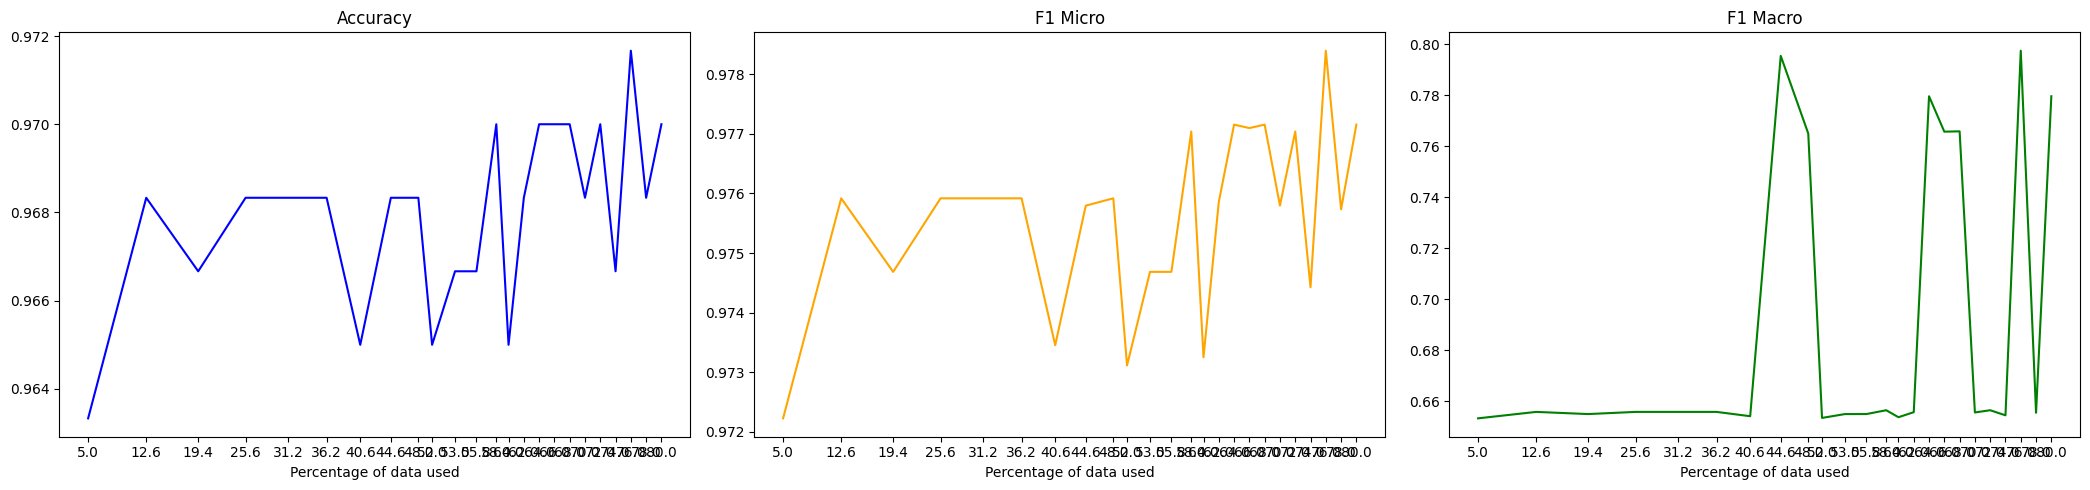

In [21]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
label num 6
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
EPOCH 1 | LOSS: 3.251922130584717 | ACCURACY: 0.9533 | F1 MACRO: 0.648 | F1 MICRO: 0.9643
EPOCH 2 | LOSS: 2.9992923736572266 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 3 | LOSS: 2.735628604888916 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 4 | LOSS: 2.838390827178955 | ACCURACY: 0.9617 | F1 MACRO: 0.6523 | F1 MICRO: 0.9709
EPOCH 5 | LOSS: 2.5351600646972656 | ACCURACY: 0.9633 | F1 MACRO: 0.653 | F1 MICRO: 0.9721
EPOCH 6 | LOSS: 2.16851806640625 | ACCURACY: 0.9617 | F1 MACRO: 0.6523 | F1 MICRO: 0.9709
in second
EPOCH 7 | LOSS: 2.004518985748291 | ACCURACY: 0.6867 | F1 MACRO: 0.3528 | F1 MICRO: 0.6846
in second
EPOCH 8 | LOSS: 1.8529973030090332 | ACCURACY: 0.8433 | F1 MACRO: 0.4992 | F1 MICRO: 0.8642
in second
EPOCH 9 | LOSS: 1.9918428659439087 | ACCURACY: 0.8433 | F1 MACRO: 0.4992 | F1 MICRO: 0.8642
in second
EPOCH 10 | LOSS: 1.752246379852295 | ACCURACY: 0

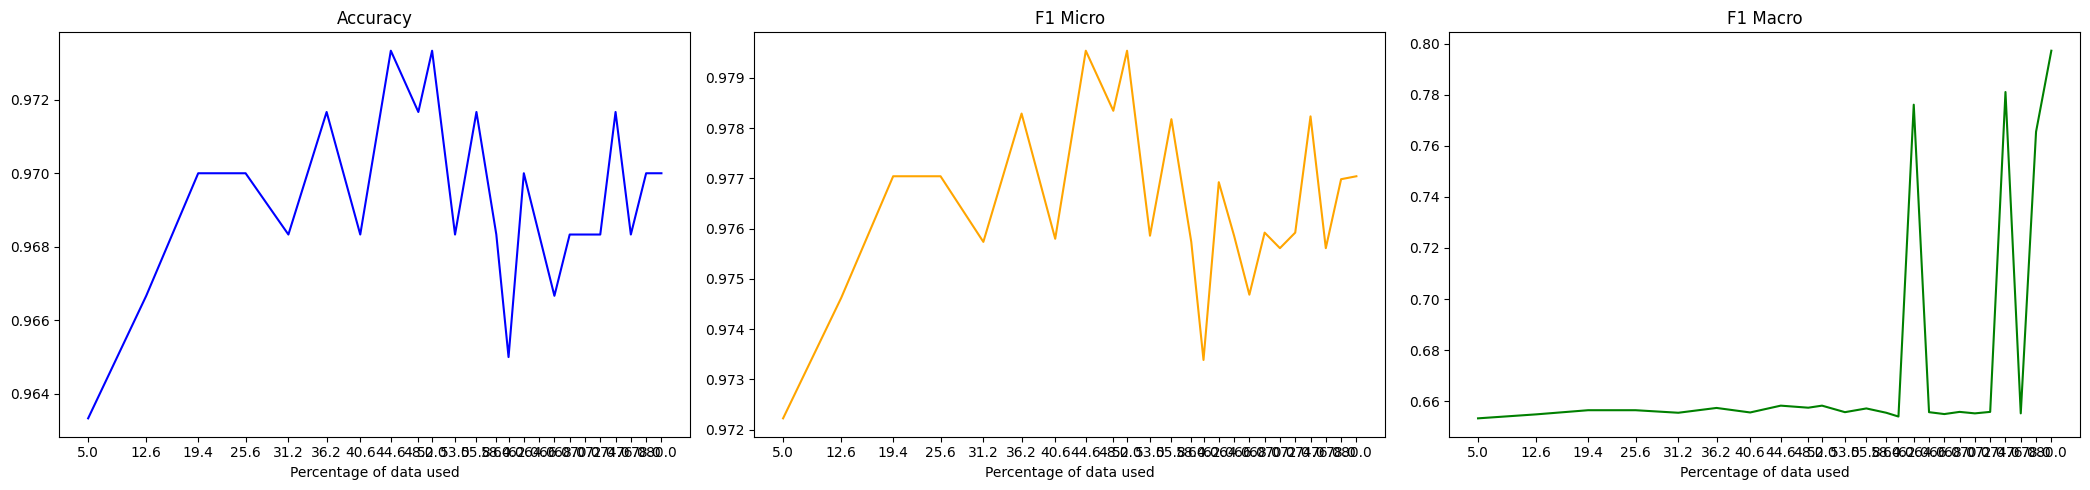

In [22]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
label num 6
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
EPOCH 1 | LOSS: 2.9500625133514404 | ACCURACY: 0.9533 | F1 MACRO: 0.6479 | F1 MICRO: 0.9644
EPOCH 2 | LOSS: 2.5768723487854004 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 3 | LOSS: 2.3555524349212646 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 4 | LOSS: 2.4594979286193848 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 5 | LOSS: 2.424105644226074 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 6 | LOSS: 2.2040233612060547 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 7 | LOSS: 2.109618902206421 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 8 | LOSS: 2.0193748474121094 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 9 | LOSS: 2.0356714725494385 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 10 | LOSS: 1.7960925102233887 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MIC

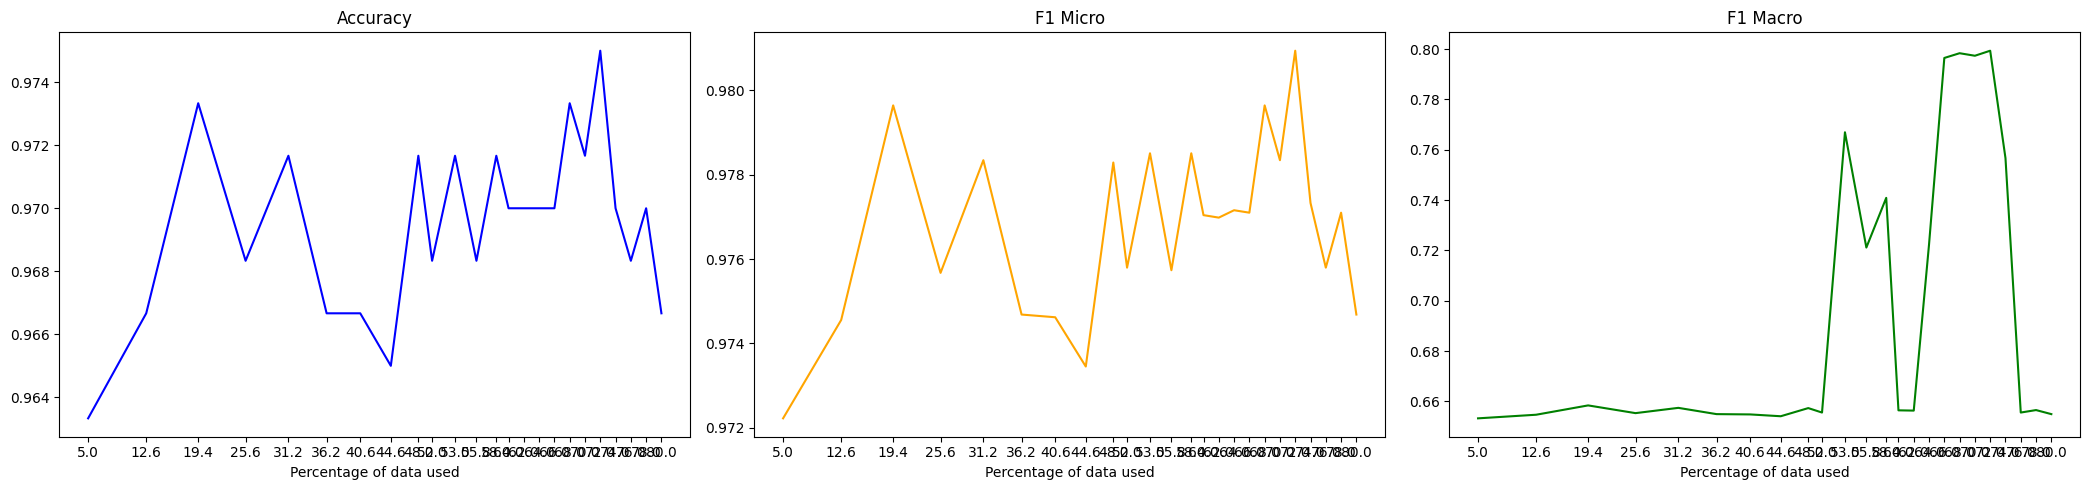

In [23]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
label num 6
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
EPOCH 1 | LOSS: 2.8872742652893066 | ACCURACY: 0.8867 | F1 MACRO: 0.6049 | F1 MICRO: 0.9091
EPOCH 2 | LOSS: 2.4212827682495117 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 3 | LOSS: 2.3006787300109863 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 4 | LOSS: 2.2029008865356445 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 5 | LOSS: 2.1076676845550537 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 6 | LOSS: 2.0887279510498047 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 7 | LOSS: 1.9087761640548706 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 8 | LOSS: 1.8241908550262451 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 9 | LOSS: 1.7624741792678833 | ACCURACY: 0.9583 | F1 MACRO: 0.6502 | F1 MICRO: 0.9682
EPOCH 10 | LOSS: 1.6928327083587646 | ACCURACY: 0.9583 | F1 MACRO: 0.6502 | F1 MI

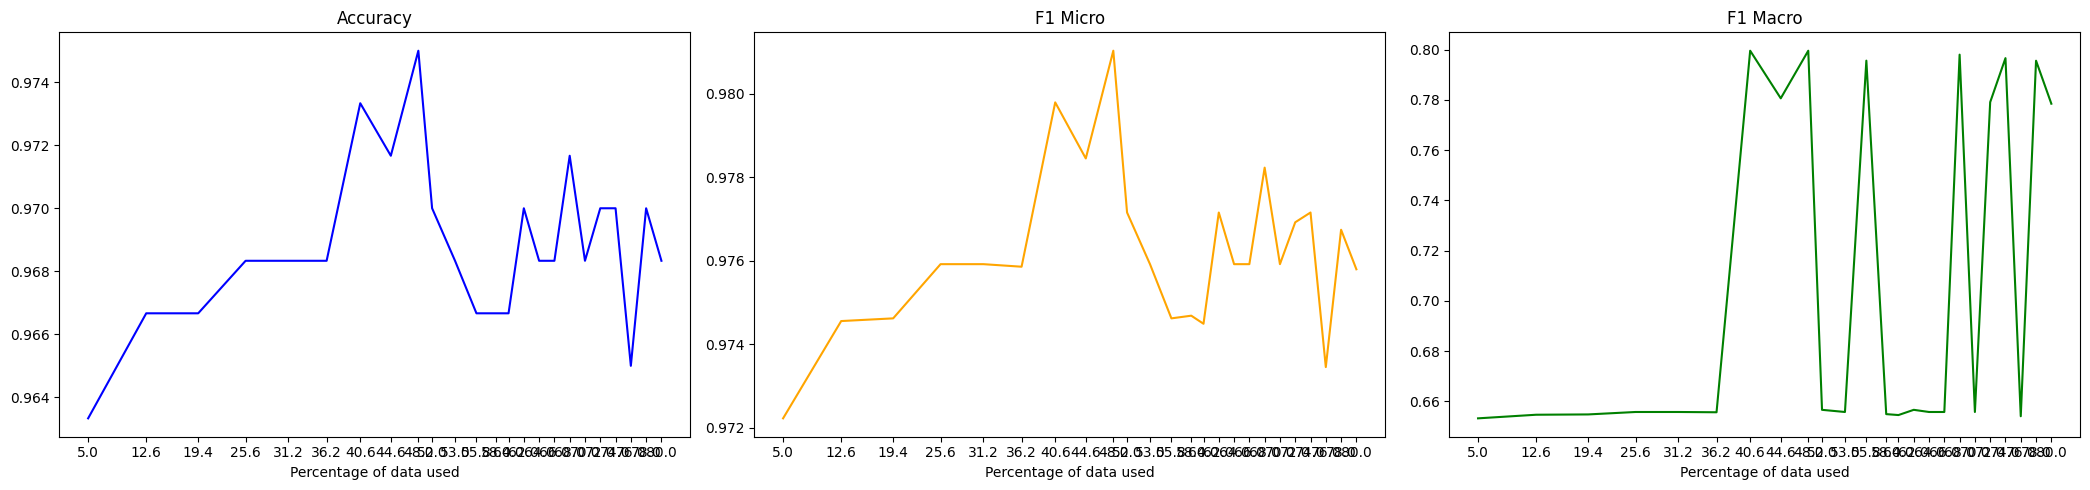

In [24]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
label num 6
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
EPOCH 1 | LOSS: 3.103121519088745 | ACCURACY: 0.7417 | F1 MACRO: 0.4444 | F1 MICRO: 0.7589
EPOCH 2 | LOSS: 2.6519675254821777 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 3 | LOSS: 2.5431437492370605 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 4 | LOSS: 2.199276924133301 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 5 | LOSS: 2.3231148719787598 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 6 | LOSS: 2.2414450645446777 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 7 | LOSS: 2.1228275299072266 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 8 | LOSS: 1.956477165222168 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 9 | LOSS: 1.9618756771087646 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO: 0.9722
EPOCH 10 | LOSS: 1.842667579650879 | ACCURACY: 0.9633 | F1 MACRO: 0.6533 | F1 MICRO

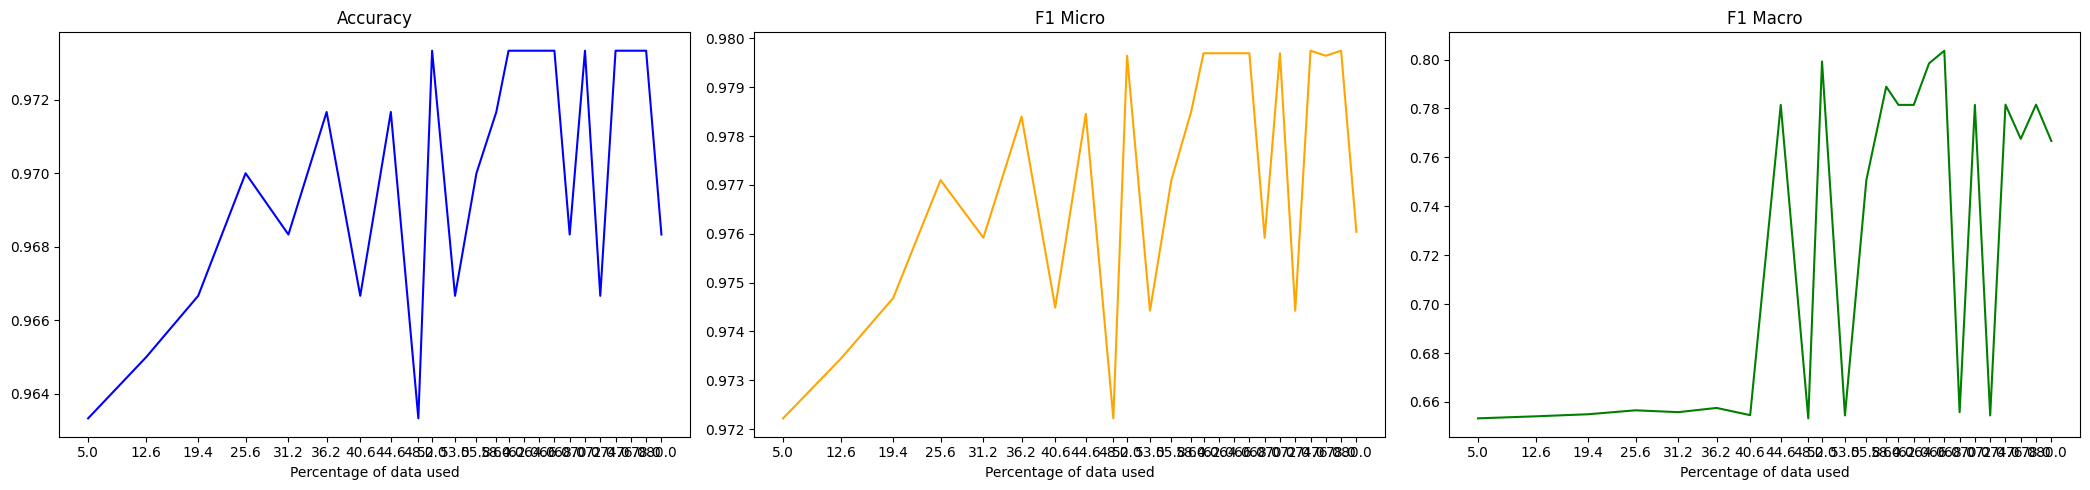

In [25]:
active_learning(seeds[4], 4)